In [11]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split

In [12]:
#Task 1.1: Load and examine structure
boston = fetch_openml(name="boston", version=1, as_frame=True) 
df = boston.frame 
X = df.drop('MEDV', axis=1) 
y = df['MEDV'] 

# Split into 80% Training and 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(df.head()) 
print(df.describe()) 

      CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  PTRATIO  \
0  0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0     15.3   
1  0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0     17.8   
2  0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0     17.8   
3  0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0     18.7   
4  0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.554695    6.284634   68.574901   
std      8.601545   23.322453    6.860353    0.115878    0.702617   28.148861   
min      0.006320    0.000000    0.460000    

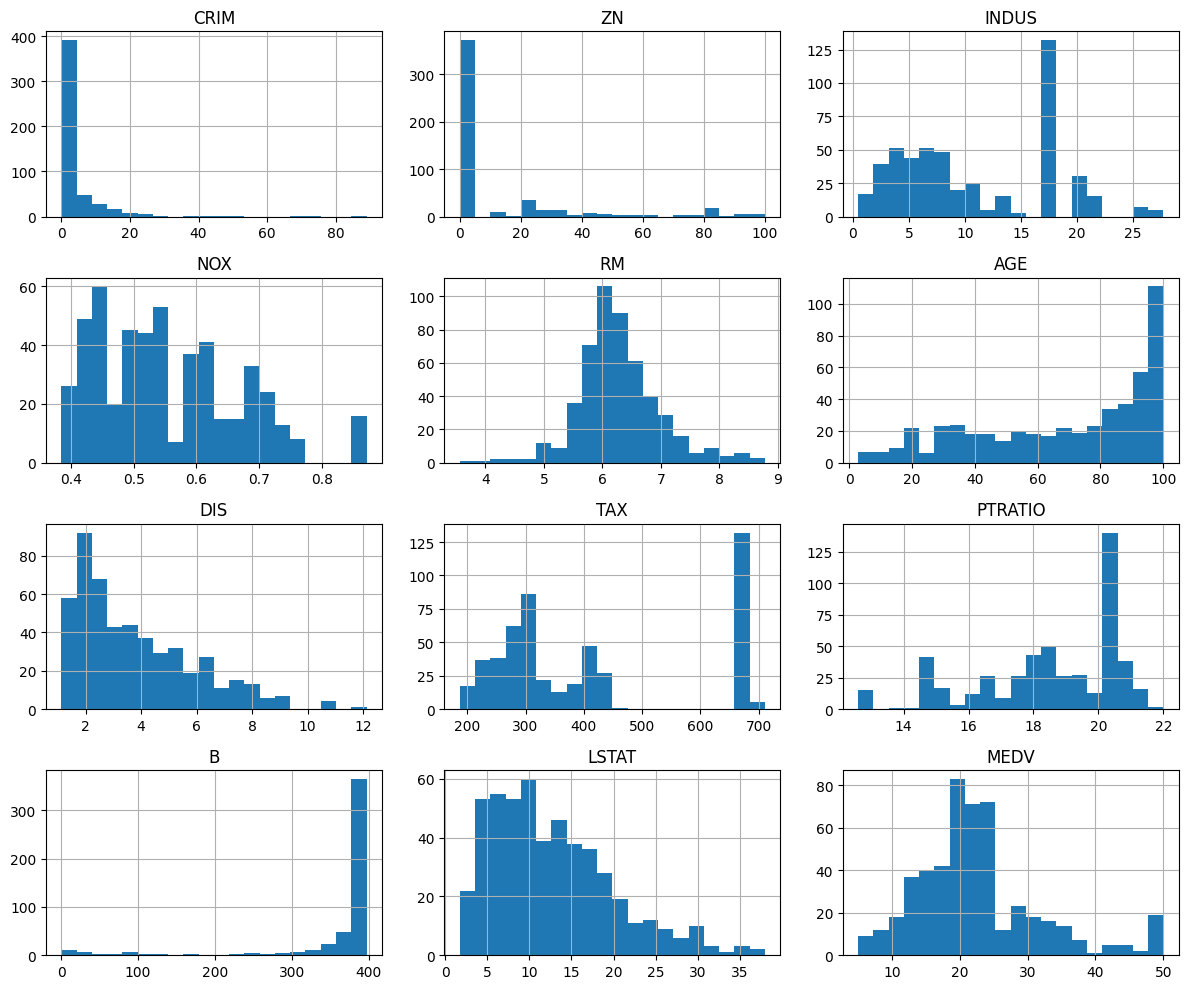

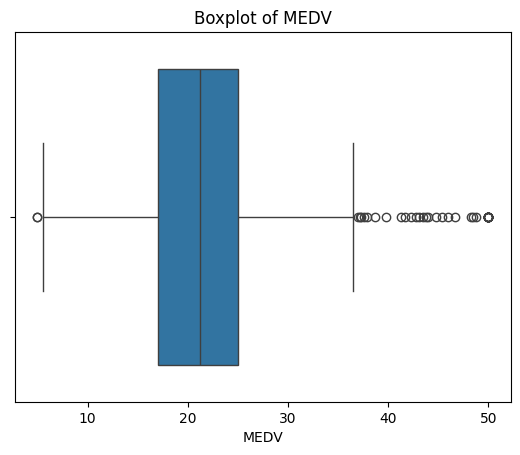

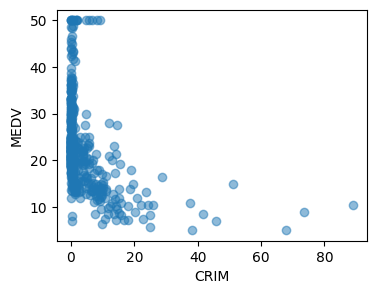

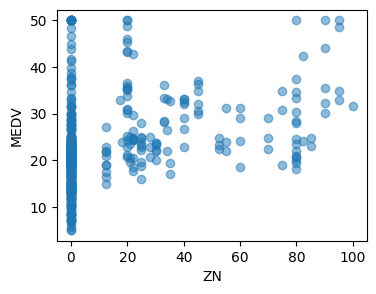

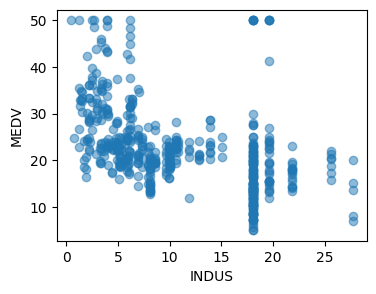

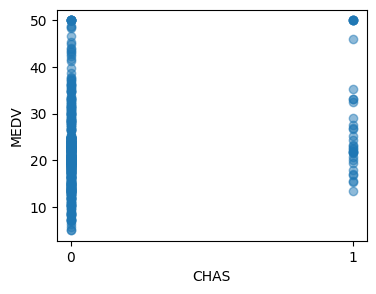

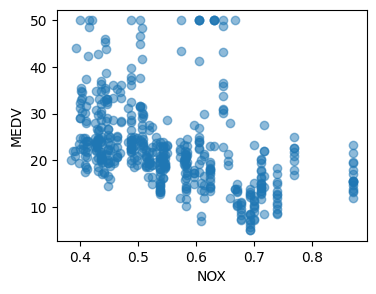

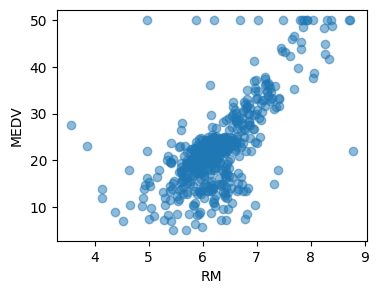

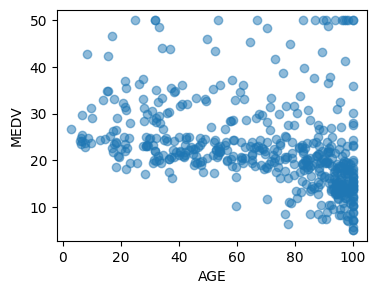

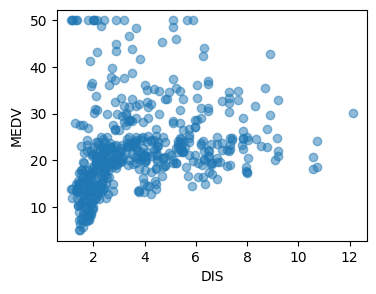

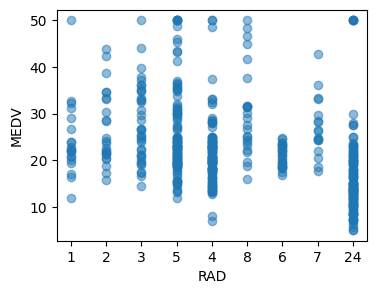

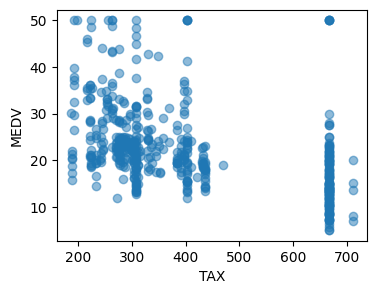

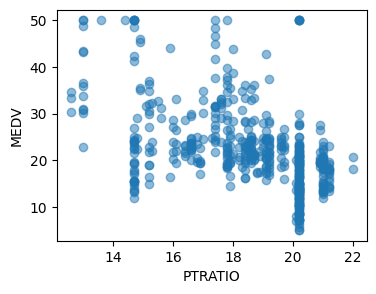

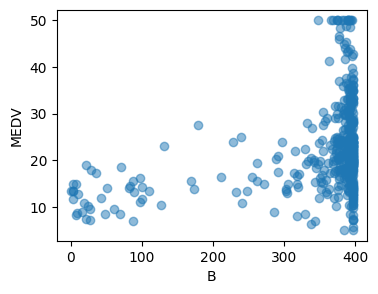

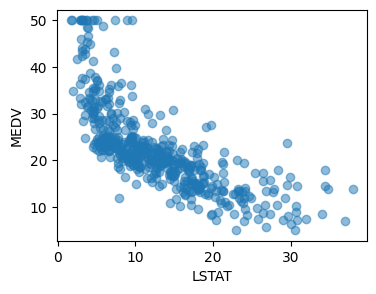

In [15]:
# Task 1.2 & 1.3
df.hist(figsize=(12, 10), bins=20) 
plt.tight_layout()
plt.show()

sns.boxplot(x=df['MEDV']) 
plt.title('Boxplot of MEDV')
plt.show()

for col in X.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(df[col], df['MEDV'], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('MEDV')
    plt.show()